In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim

/home/erikw26/Conda/sciml2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        for n in range(-len(c)//2, len(c)//2 + 1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000
# dataset = FourierSeriesDataset(num_samples, num_points)

# # Create DataLoader
# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# torch.save(dataset, 'derivative_dataset.pt')

    

## Load previously saved dataset

In [4]:
dataset = torch.load('derivative_dataset.pt')

In [5]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
print(len(train_dataloader))

250


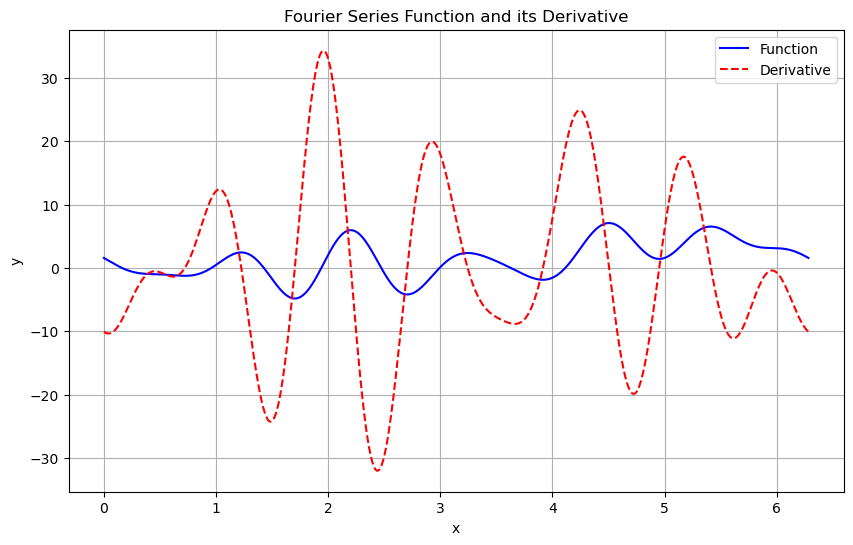

In [8]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)
train_dataloader_viz = DataLoader(train_dataset, batch_size=1, shuffle=True)

plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

In [9]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

## Training loop

In [10]:
# Training loop
train_losses = []
test_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    test_loss = 0.0

    for batch_functions, batch_derivatives in train_dataloader:
        # Reshape input: [batch_size, 1, num_points]
        batch_functions = batch_functions.unsqueeze(1)
        batch_derivatives = batch_derivatives.unsqueeze(1)

        # Forward pass
        outputs = model(batch_functions)
        loss = criterion(outputs, batch_derivatives)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    model.eval()
    with torch.no_grad():
        for b_test_functions, b_test_derivatives in test_dataloader:
            b_test_functions = b_test_functions.unsqueeze(1)
            b_test_derivatives = b_test_derivatives.unsqueeze(1)

            test_outputs = model(b_test_functions)
            batch_test_loss = criterion(test_outputs, b_test_derivatives)

            test_loss += batch_test_loss.item()

    test_loss /= len(test_dataloader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


# Save the model
torch.save(model.state_dict(), 'model_weights.pth')

# To load the model later:
# model = SimpleCNN()
# model.load_state_dict(torch.load('fourier_derivative_model.pth'))
# model.eval()

print("Training finished!")

Epoch [1/100], Train Loss: 84.9189, Test Loss: 14.5304
Epoch [2/100], Train Loss: 9.1598, Test Loss: 5.7071
Epoch [3/100], Train Loss: 3.8765, Test Loss: 2.5903
Epoch [4/100], Train Loss: 2.0376, Test Loss: 1.4600
Epoch [5/100], Train Loss: 1.2582, Test Loss: 1.0952
Epoch [6/100], Train Loss: 1.1933, Test Loss: 1.1131
Epoch [7/100], Train Loss: 0.9447, Test Loss: 0.8779
Epoch [8/100], Train Loss: 0.8701, Test Loss: 1.1701
Epoch [9/100], Train Loss: 0.8184, Test Loss: 0.7512
Epoch [10/100], Train Loss: 0.8037, Test Loss: 0.6879
Epoch [11/100], Train Loss: 0.7364, Test Loss: 0.6744
Epoch [12/100], Train Loss: 0.6599, Test Loss: 0.6162
Epoch [13/100], Train Loss: 0.7439, Test Loss: 0.6363
Epoch [14/100], Train Loss: 0.7746, Test Loss: 0.5617
Epoch [15/100], Train Loss: 0.5616, Test Loss: 0.5514
Epoch [16/100], Train Loss: 0.5501, Test Loss: 0.5235
Epoch [17/100], Train Loss: 0.5335, Test Loss: 0.5094
Epoch [18/100], Train Loss: 0.6027, Test Loss: 0.5156
Epoch [19/100], Train Loss: 0.5483,

In [18]:
def plot_losses(train_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    plt.show()

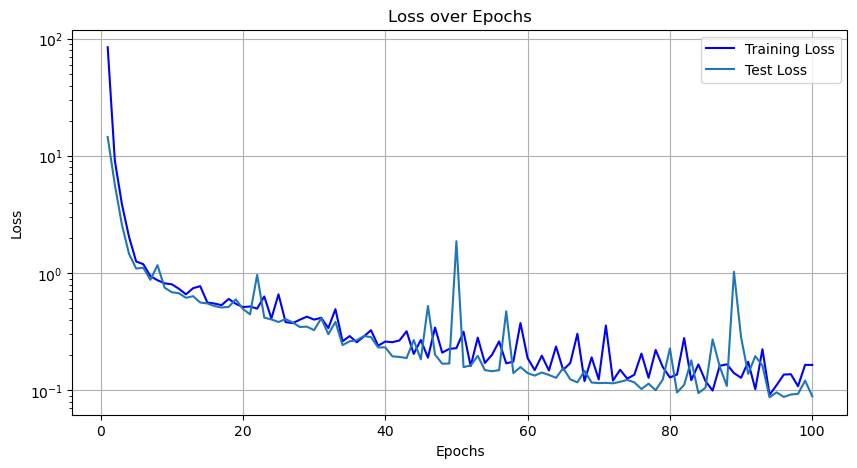

In [19]:
plot_losses(train_losses=train_losses, test_losses=test_losses)

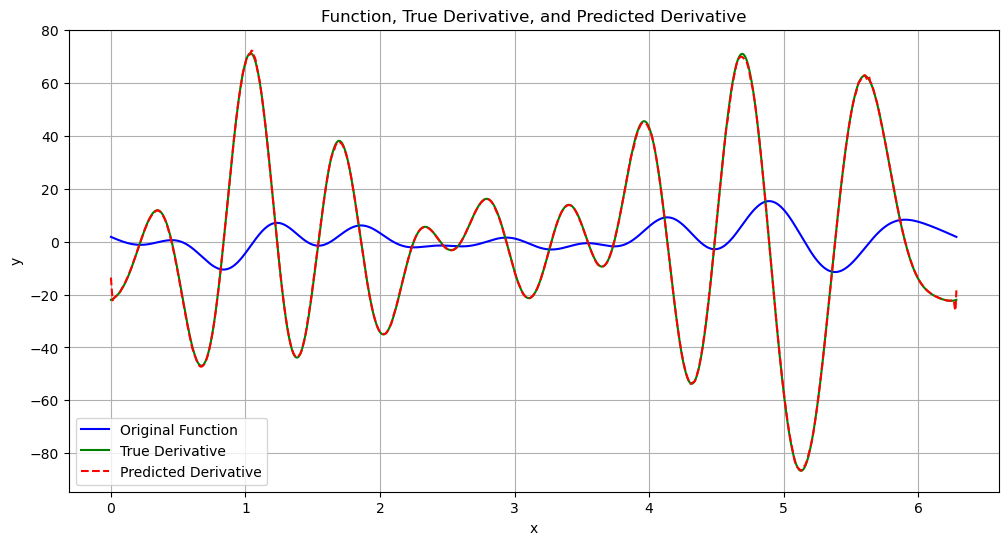

In [20]:
model.eval()  # Set the model to evaluation mode

train_dataloader_viz
# Get a random sample from the dataloader
dataiter = iter(train_dataloader_viz)
function, true_derivative = next(dataiter)

# Reshape the input for the model
function = function.unsqueeze(1)  # Add channel dimension

# Make prediction
with torch.no_grad():
    predicted_derivative = model(function)

# Convert tensors to numpy arrays for plotting
x = torch.linspace(0, 2*torch.pi, 1000).numpy()
function = function.squeeze().numpy()
true_derivative = true_derivative.squeeze().numpy()
predicted_derivative = predicted_derivative.squeeze().numpy()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x, function, label='Original Function', color='blue')
plt.plot(x, true_derivative, label='True Derivative', color='green')
plt.plot(x, predicted_derivative, label='Predicted Derivative', color='red', linestyle='--')
plt.title('Function, True Derivative, and Predicted Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
percent_changes = [(test_losses[i] - test_losses[i - 1]) / test_losses[i - 1] * 100 for i in range(1, len(test_losses))]
num_above_5 = len([change for change in percent_changes if abs(change) > 5])



In [25]:
len(test_losses)

100

In [24]:
num_above_5

71